In [1]:
import pandas as pd
import numpy as np
import os, pickle, datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load and combine the files
series = pd.read_csv('./WDISeries.csv')
series = series[['Series Code', 'Topic', 'Long definition', 
                 'Unit of measure', 'Periodicity', 'Base Period']]
countries = pd.read_csv('./WDICountry.csv')
countries.dropna(subset = ['Currency Unit'], inplace=True)
countries = countries[['Country Code', 'Short Name', 'Region', 'Income Group']]
df = pd.read_csv('./WDICSV.csv')
df = pd.merge(df, series, left_on=['Indicator Code'], right_on=['Series Code'], how='left')
df = pd.merge(df, countries, left_on=['Country Code'], right_on=['Country Code'], how='inner')

In [3]:
# Load and clean UN data
un_hdi = pd.read_excel("HDR25_Statistical_Annex_HDI_Table.xlsx", header=4)
un_hdi = un_hdi[['Unnamed: 1','Human Development Index (HDI) ']]
un_hdi.rename(columns={'Unnamed: 1': 'Country', 'Human Development Index (HDI) ':'UN HDI'}, inplace=True)
un_hdi = un_hdi.iloc[3:,:]
un_hdi = un_hdi.dropna()

In [4]:
# Transform the data so that each metric is in its own column
metrics = [
    'Life expectancy at birth, total (years)',
    'Life expectancy at birth, female (years)',
    'Compulsory education, duration (years)',
    'Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative)',
    'Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)',
    'Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative)',
    'Educational attainment, at least completed primary, population 25+ years, female (%) (cumulative)',
    'Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative)',
    'Educational attainment, at least completed upper secondary, population 25+, female (%) (cumulative)',
    'GNI per capita, PPP (current international $)',
    'GDP per capita, PPP (current international $)',
    'GDP, PPP (current international $)',
    'Access to electricity (% of population)',
    'Physicians (per 1,000 people)',
    'Individuals using the Internet (% of population)',
    'People with basic handwashing facilities including soap and water (% of population)',
    'Suicide mortality rate (per 100,000 population)'
]

for metric in metrics:
    df[metric] = np.where(df['Indicator Name'] == metric, df['2023'], np.nan)

    # try to fill in missing values with previous years of data
    for year in range(2022,2014,-1):
        mask = (df['Indicator Name'] == metric) & (pd.isna(df[metric]))
        df.loc[mask, metric] = df.loc[mask, f'{year}']

cols_to_keep = ['Country Code'] + metrics

df_metrics = df[cols_to_keep].groupby(['Country Code']).agg('mean').reset_index()
df_metrics.shape

(217, 18)

In [5]:
df_metrics.dropna(
    subset=[
    'Life expectancy at birth, total (years)',
    'Life expectancy at birth, female (years)',
    'Compulsory education, duration (years)',
    'Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative)',
    'Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)',
    'Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative)',
    'Educational attainment, at least completed primary, population 25+ years, female (%) (cumulative)',
    'Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative)',
    'Educational attainment, at least completed upper secondary, population 25+, female (%) (cumulative)',
    'GNI per capita, PPP (current international $)',
    'GDP per capita, PPP (current international $)',
    'GDP, PPP (current international $)'],
    inplace=True)
df_metrics.shape
# 46 countries dropped due to missing data

(171, 18)

In [6]:
# Sample 100 countries from the data
df_sample = df_metrics.sample(n=100, random_state=123)

In [7]:
# Add log-income metrics
df_sample['Log_GNI per capita, PPP'] = np.log(df_sample['GNI per capita, PPP (current international $)'])
df_sample['Log_GDP, PPP'] = np.log(df_sample['GDP, PPP (current international $)'])
df_sample['Log_GDP per capita, PPP'] = np.log(df_sample['GDP per capita, PPP (current international $)'])

In [8]:
metrics.append('Log_GNI per capita, PPP')

# Apply MinMaxScaler to the metrics
scaler = MinMaxScaler()
df_relative = df_sample.copy()
df_relative[metrics] = scaler.fit_transform(df_relative[metrics])

In [9]:
# Now we use the UN cutoffs for alternative HDI estimates
df_absolute = df_sample.copy()

# https://hdr.undp.org/sites/default/files/2023-24_HDR/hdr2023-24_technical_notes.pdf
# Life expectancy cutoff is 20 to 85
for var in ['Life expectancy at birth, total (years)','Life expectancy at birth, female (years)']:
    df_absolute[var] = (df_absolute[var] - 20) / (85 - 20)

# Education is 0 to 15 years
for var in ['Compulsory education, duration (years)']:
    df_absolute[var] = (df_absolute[var] - 0) / (18 - 0)

# Education attainment is 0 to 100%
for var in ['Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative)',
            'Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)',
            'Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative)',
            'Educational attainment, at least completed primary, population 25+ years, female (%) (cumulative)',
            'Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative)',
            'Educational attainment, at least completed upper secondary, population 25+, female (%) (cumulative)']:
    df_absolute[var] = (df_absolute[var] - 0) / (100 - 0)

# Log Income uses actual min and max values
for var in ['Log_GNI per capita, PPP']:
    df_absolute[var] = (df_absolute[var] - df_absolute[var].min()) / (df_absolute[var].max() - df_absolute[var].min())

In [10]:
# Average the education metrics
for df in [df_relative, df_absolute]:
    df['Avg_Education'] = df[[
        'Compulsory education, duration (years)',
        'Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative)',
        'Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)',
        'Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative)'
    ]].mean(axis=1)

    df['Avg_Education_Female'] = df[[
        'Compulsory education, duration (years)',
        'Educational attainment, at least completed primary, population 25+ years, female (%) (cumulative)',
        'Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative)',
        'Educational attainment, at least completed upper secondary, population 25+, female (%) (cumulative)'
    ]].mean(axis=1)

In [11]:
# Now take the geometric mean to get HDI estimates
for df in [df_relative, df_absolute]:
    df['HDI'] = df[['Life expectancy at birth, total (years)','Avg_Education','Log_GNI per capita, PPP']].prod(axis=1) ** (1/3)
    df['HDI_Female'] = df[['Life expectancy at birth, female (years)','Avg_Education_Female','Log_GNI per capita, PPP']].prod(axis=1) ** (1/3)

In [12]:
# Extra HDI metric that uses additional fields
extra_fields = [
    'Access to electricity (% of population)',
    'Physicians (per 1,000 people)',
    'Individuals using the Internet (% of population)',
    'People with basic handwashing facilities including soap and water (% of population)',
    'Suicide mortality rate (per 100,000 population)'
    ]

# Replace each field with the average value if missing
for i in extra_fields:
    m = df_relative[i].mean()
    df_relative[i] = np.where(df_relative[i].isna(), m, df_relative[i])

df_relative['Avg_Extra'] = df_relative[extra_fields].mean(axis=1)
df_relative['HDI_Extra'] = df_relative[['Life expectancy at birth, total (years)','Avg_Education','Log_GNI per capita, PPP','Avg_Extra']].prod(axis=1) ** (1/4)

In [13]:
# Put the results into a df
df_relative.rename(columns={
    'HDI': 'HDI_Relative',
    'HDI_Female': 'HDI_Relative_Female'
}, inplace=True)
df_relative = df_relative[['Country Code', 'HDI_Relative', 'HDI_Relative_Female', 'HDI_Extra']]

df_absolute.rename(columns={
    'HDI': 'HDI_Absolute',
    'HDI_Female': 'HDI_Absolute_Female'
}, inplace=True)
df_absolute = df_absolute[['Country Code', 'HDI_Absolute', 'HDI_Absolute_Female', 'GDP, PPP (current international $)', 'Log_GDP, PPP', 'Log_GDP per capita, PPP']]

df_results = pd.merge(df_relative, df_absolute, on='Country Code', how='inner')
df_results = pd.merge(df_results, countries, on='Country Code', how='inner')

In [14]:
# Join with UN HDI data
# String cleaning for country names
df_results['Country'] = df_results['Short Name'].case_when([
    (df_results['Short Name'] == 'Bahamas, The', 'The Bahamas'),
    (df_results['Short Name'] == 'Bolivia, Plurinational State of', 'Bolivia (Plurinational State of)'),
    (df_results['Short Name'] == 'Congo, Democratic Republic of', 'Congo (Democratic Republic of the)'),
    (df_results['Short Name'] == 'Egypt, Arab Republic of', 'Egypt'),
    (df_results['Short Name'] == 'Iran, Islamic Republic of', 'Iran (Islamic Republic of)'),
    (df_results['Short Name'] == 'Kyrgyz Republic', 'Kyrgyzstan'),
    (df_results['Short Name'] == 'Lao PDR', "Lao People's Democratic Republic")
    ])
df_results = pd.merge(df_results, un_hdi, on='Country', how='left')

In [15]:
# Correlations
df_results.rename(columns={
    'GDP, PPP (current international $)': 'GDP, PPP',
    'HDI_Relative': 'HDI Relative', 
    'HDI_Relative_Female': 'HDI Relative Female', 
    'HDI_Absolute': 'HDI Absolute', 
    'HDI_Absolute_Female': 'HDI Absolute Female',  
    'Log_GDP, PPP': 'Log GDP, PPP',
    'HDI_Extra': 'HDI with Extra Fields'
    }, inplace=True)

corr = df_results[['HDI Relative', 'HDI Relative Female', 'HDI Absolute', 'HDI Absolute Female', 'HDI with Extra Fields', 'UN HDI', 'GDP, PPP', 'Log GDP, PPP']].corr()
print(corr.iloc[:,:5])
corr = corr.iloc[:,:4]

# Save the results to a tex file
corr.to_latex('./output/correlation_results.tex',
              caption='Correlation Results',
              float_format="%.3f")

                       HDI Relative  HDI Relative Female  HDI Absolute  \
HDI Relative               1.000000             0.998190      0.977882   
HDI Relative Female        0.998190             1.000000      0.978516   
HDI Absolute               0.977882             0.978516      1.000000   
HDI Absolute Female        0.977142             0.980220      0.998883   
HDI with Extra Fields      0.994907             0.995755      0.974306   
UN HDI                     0.976424             0.974710      0.974085   
GDP, PPP                   0.131357             0.125901      0.130554   
Log GDP, PPP               0.304193             0.285773      0.311113   

                       HDI Absolute Female  HDI with Extra Fields  
HDI Relative                      0.977142               0.994907  
HDI Relative Female               0.980220               0.995755  
HDI Absolute                      0.998883               0.974306  
HDI Absolute Female               1.000000               0.97

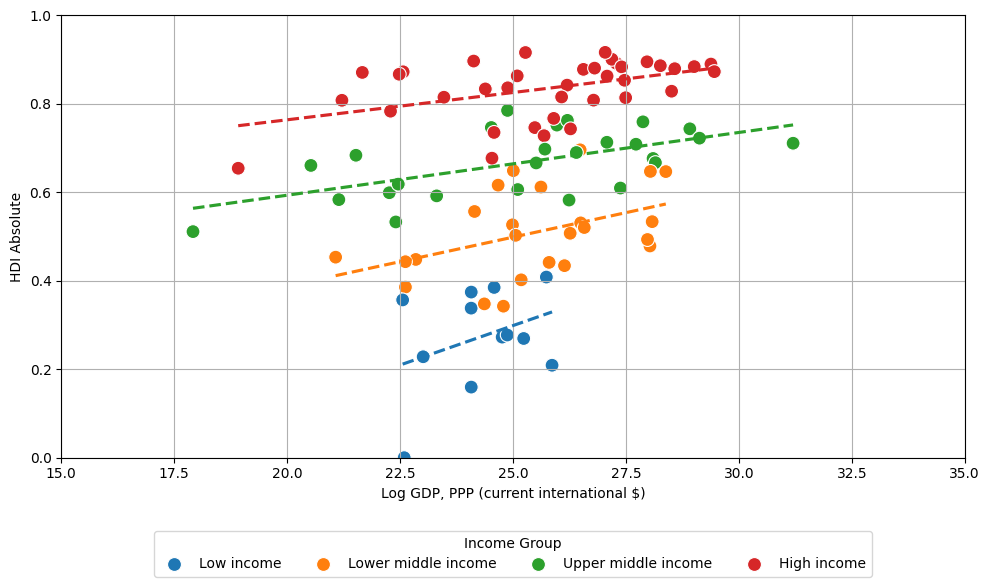

In [16]:
# Scatter plot of 'Log_GDP, PPP' vs 'HDI_Absolute'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_results, x='Log GDP, PPP', y='HDI Absolute', hue='Income Group', s=100)

income_groups = df_results['Income Group'].unique()
palette = dict(zip(income_groups, sns.color_palette(n_colors=len(income_groups))))

for group in income_groups:
    group_data = df_results[df_results['Income Group'] == group]
    sns.regplot(
        x='Log GDP, PPP',
        y='HDI Absolute',
        data=group_data,
        scatter=False,
        color=palette[group],
        ci=None,
        line_kws={'linestyle': '--'}
    )

plt.xlabel('Log GDP, PPP (current international $)')
plt.ylabel('HDI Absolute')
plt.legend(title='Income Group', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(income_groups))
plt.ylim(0,1)
plt.xlim(15,35)
plt.grid(True)
plt.tight_layout()
plt.savefig("./output/Scatterplot HDI Absolute.png")
plt.show()

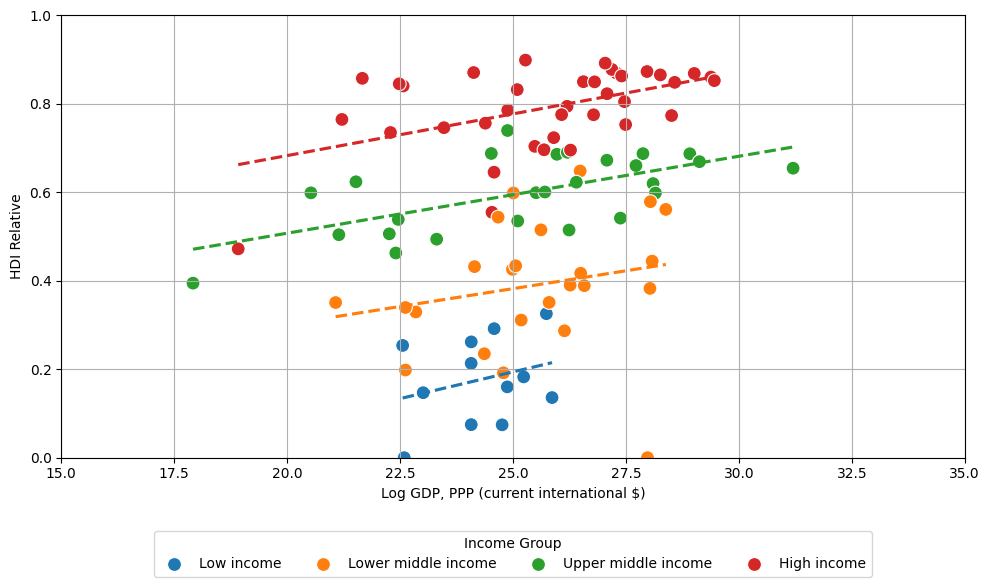

In [17]:
# Scatter plot of 'Log_GDP, PPP' vs 'HDI_Relative'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_results, x='Log GDP, PPP', y='HDI Relative', hue='Income Group', s=100)

income_groups = df_results['Income Group'].unique()
palette = dict(zip(income_groups, sns.color_palette(n_colors=len(income_groups))))

for group in income_groups:
    group_data = df_results[df_results['Income Group'] == group]
    sns.regplot(
        x='Log GDP, PPP',
        y='HDI Relative',
        data=group_data,
        scatter=False,
        color=palette[group],
        ci=None,
        line_kws={'linestyle': '--'}
    )

plt.xlabel('Log GDP, PPP (current international $)')
plt.ylabel('HDI Relative')
plt.legend(title='Income Group', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(income_groups))
plt.ylim(0,1)
plt.xlim(15,35)
plt.grid(True)
plt.tight_layout()
plt.savefig("./output/Scatterplot HDI Relative.png")
plt.show()